# Sequential Gausssian Simulation

### Reasoning for building a SGSIM model:
- We want to have a complete spatial model that honors the global distribution and variogram of our data.

Kriging gives the most likely value at each location in a spatial model, and at distances greater than the range, simple kriging assusmes those locations are the global mean of the data. This effect often misses the 
short-range variability and heterogeneity in geospatial data.
- SGSIM corrects for Kriging's low model variance by working in gaussian space, where high values and low values tend not to bunch up. (honors global distribution / histogram)
- SGSIM corrects for Kriging's continuous variogram or 'smoothness' (honors spatial variablity)

In [310]:
import os                                                  
import numpy as np                                        
import pandas as pd                                       
import matplotlib.pyplot as plt    

import pprint
import math
import scipy
import random
from numpy.random import randn
from scipy.stats import norm
from IPython.display import Image
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

In [311]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

Set working directory

In [24]:
# os.chdir("C:\Users\admin1\Desktop\resources\CSE Project")                                  

Lets start by creating a Gaussian distrubted porosity dataset.

In [62]:
porosity = np.array([])
for i in range(100):
    porosity = np.append(porosity,random.random()*(.2-.1) + .1)

#Gaussian transformation:
porosity = pd.DataFrame(porosity, columns = ['porosity'])
#df_iso['Npor'], tvPor, tnsPor = geostats.nscore(df_iso, 'porosity')

porosity.describe()

,porosity
count,100.000000
mean,0.151818
std,0.029137
min,0.100088
25%,0.127565
50%,0.154236
75%,0.175539
max,0.199387


To make this Spatial data, lets import a porosity data set that we will use later. We will extract the X and Y locations from this spreadsheet for convenience.

Then we'll visualize the data.

C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:323: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(


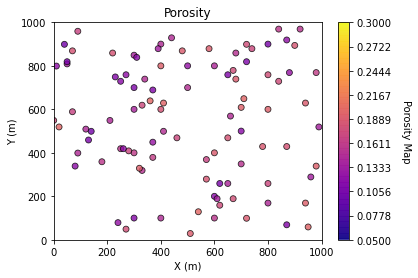

In [26]:
data = pd.read_csv('sample_data_MV_biased-3.csv')
data = data.sample(100)
data = data.reset_index(drop = True)
df_iso = pd.DataFrame(data.iloc[:,1:3],columns = ['X','Y'])
df_iso['porosity'] = porosity['porosity']

df_iso.head()

GSLIB.locmap_st(df_iso,'X','Y','porosity',0,1000,0,1000,.05,.3,'Porosity','X (m)','Y (m)','Porosity Map',plt.cm.plasma)

In the case our data is Anisotropic, we wont have an isotropic variogram and will need determine the major and minor azimuths for our SGSIM model. 

For this we can calculate the variogram in all directions and visaully determine our major and minor azimuths.

Build a dataframe needed to use our working data using csv format.

In [27]:
df = pd.read_csv('sample_data_MV_biased-3.csv')
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,293.260870,499.565217,520.644022,0.597826,0.127026,85.617362,4791.736646
std,169.058258,289.770794,277.412187,0.491004,0.030642,228.362654,974.560569
min,0.000000,0.000000,9.000000,0.000000,0.041122,0.094627,1981.177309
25%,150.500000,240.000000,269.000000,0.000000,0.103412,2.297348,4110.728374
50%,296.000000,500.000000,539.000000,1.000000,0.125842,10.377292,4713.325533
75%,439.500000,762.500000,769.000000,1.000000,0.148623,50.581288,5464.043562
max,586.000000,990.000000,999.000000,1.000000,0.210258,1991.097723,7561.250336


To fully appreciate the models we will build, lets reduce the number of true data points

In [28]:
df = df.sample(100)
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,279.350000,414.300000,545.200000,0.650000,0.132202,100.446735,4701.852684
std,157.742046,297.729641,280.466711,0.479372,0.032612,276.503207,976.308415
min,0.000000,0.000000,9.000000,0.000000,0.066231,0.156520,2914.857130
25%,139.500000,140.000000,300.000000,0.000000,0.107298,3.335530,4010.619460
50%,291.500000,380.000000,574.000000,1.000000,0.136061,12.545962,4584.708253
75%,409.750000,652.500000,800.000000,1.000000,0.154090,62.111733,5446.258809
max,581.000000,990.000000,999.000000,1.000000,0.210258,1991.097723,7561.250336


Lets visualize our spatial data

C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:323: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(


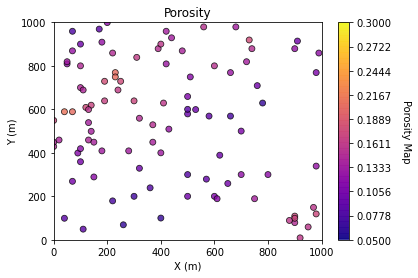

In [29]:
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,.05,.3,'Porosity','X (m)','Y (m)','Porosity Map',plt.cm.plasma)

- From this map, we can get a sense of the minimum lag distance we want to use for our variogram. 50m seems reasonable given the proximity of data. 
- Now lets calculate the variogram of our truth model. We are going to determine the correct major and minor variogram azimuths by measuring the ranges of multiple variogram calculations.

Lets transform our data to normal score, this is a requiremnet for our future SGSIM models.


In [30]:
df['nPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity')
df.head()
por = pd.DataFrame(df.iloc[:,1:3])
por.head()
por['nPor'] = df['nPor']
por.head()

df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,nPor
284,451,320.0,559.0,1.0,0.149400,131.864248,4332.562518,0.510073
86,135,140.0,619.0,1.0,0.169469,199.029886,3358.271778,1.103063
2,2,100.0,700.0,1.0,0.145912,17.818143,3586.988513,0.398855
264,420,90.0,399.0,1.0,0.116078,2.685214,4880.110978,-0.510073
31,43,500.0,200.0,0.0,0.103559,1.646428,7561.250336,-0.755415


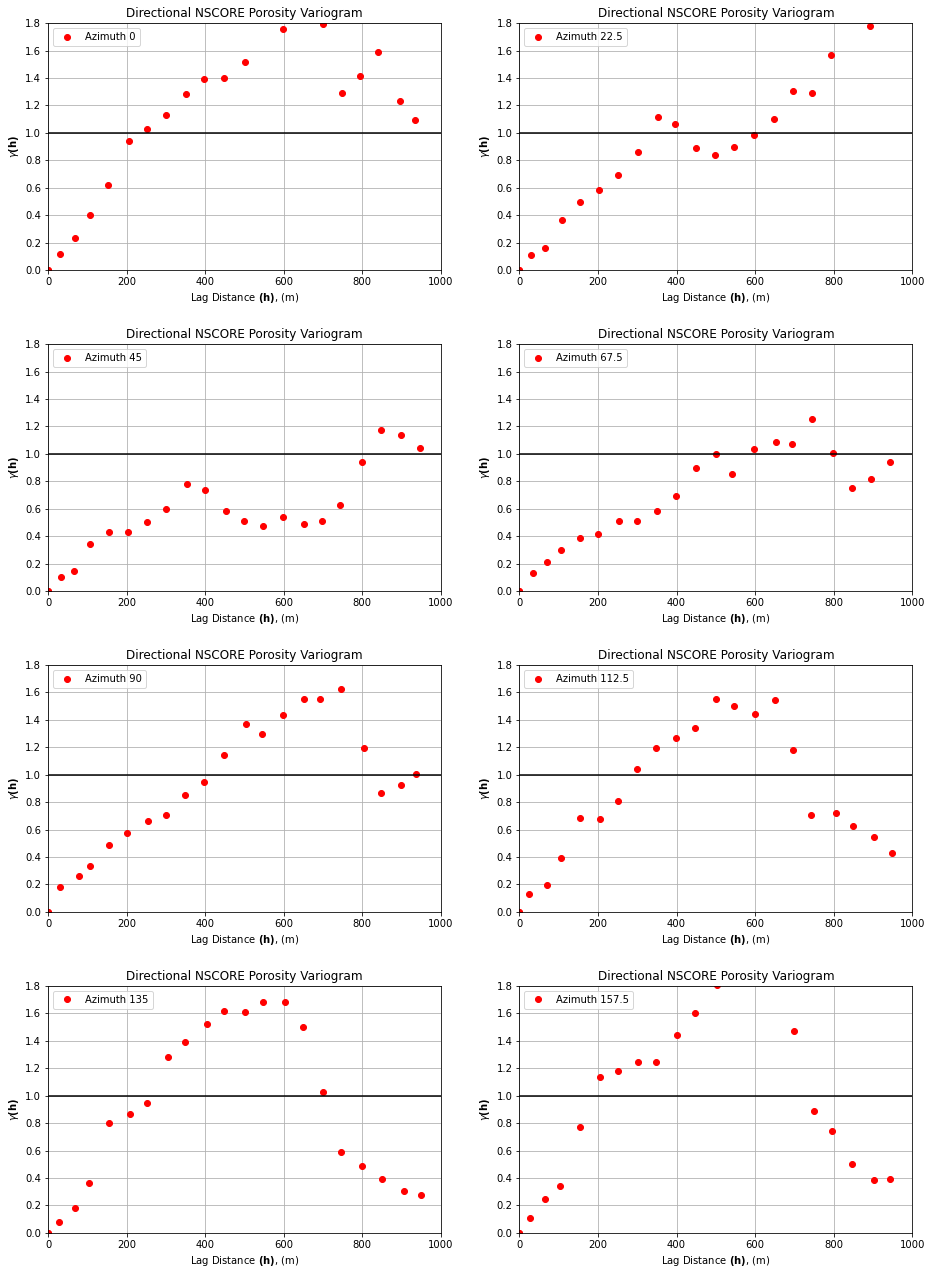

In [31]:
tmin = -9999.; tmax = 9999.                             # no trimming of our data 
lag_dist = 50.0; lag_tol = 50.0; nlag = 20;     # maximum lag is 1000m, log_tol > 1/2 lag distance (smoothing)
bandh = 9999.9; atol = 25                             # give bandwidth no effect: directional variograms
isill = 1                                               # standardize sill(equal to variance = 1 in normal trans)
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider

#Store results in these arrays
lag = np.zeros((len(azi_mat),nlag+2))
variogram = np.zeros((len(azi_mat),nlag+2))
z = np.zeros((len(azi_mat),nlag+2))

for azi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[azi,:], variogram[azi,:], z[azi,:] = geostats.gamv(por,"X","Y","nPor",tmin,tmax,
                                                                lag_dist,lag_tol,nlag,azi_mat[azi],
                                                                atol,bandh,isill)
#visualize each variogram 
    plt.subplot(4,2,azi+1)
    plt.plot(lag[azi,:],variogram[azi,:],'o',color = 'r',label = 'Azimuth ' +str(azi_mat[azi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,1000])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

By exploring a range of directions, we have built a spatial continuity elipse of our data. We see that our major axis is 45 degrees (Range = 600m) and our minor axis is 135 degrees (Range = 300m). We will use these azimuths for our SGSIM model, so that the model is consistent with our data going foward.

For now lets work with our isotropic, Gaussian distrubted porosity data. This means we can use an isotropic variogram in our SGSIM model: 
- hmin = hmax

Lets build a SGSIM model using simple kriging estimator, to do this we will implement the SGSIM fuction from
geostatspy library and set the fuction parameter 'ktype' = 0

- By using simple kriging we are not constraining the weights assigned to data to model (as done in ordianry kriging where sum of weights = 1 and the global mean of data does not need to be known, local mean is used instead), and we are working with the residual from the mean. Doing so assumes stationarity in our data i.e. no trends in the data.


 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = 0.1558
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9873
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0371 (close to 0.0?)
                                   variance = 0.9779 (close to gammabar(V,V)? approx. 1.0)


C:\Users\admin1\anaconda3\lib\site-packages\geostatspy\GSLIB.py:700: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  plt.scatter(


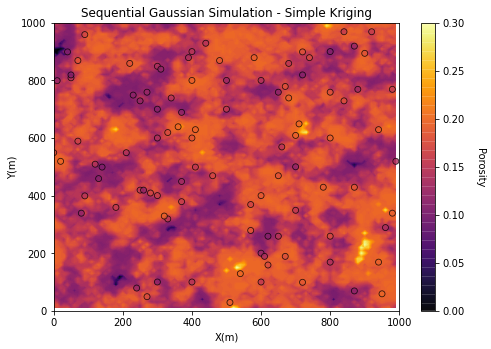

In [144]:
# we are setting our working variables that will be inputs to our sgsim fuction
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 400; skmean = 0

#instatiation of a variogram model with necessary function parameters nugget effect, major & minor ranges, 
#azimuth, etc. 
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=100,hmin1=100)

#trimming limits (no effect on data)
tmin = -999; tmax = 999

#SGSIM model
sim_sk = geostats.sgsim(df_iso,'X','Y','porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

#visualize created SGSIM model
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(111)  
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df_iso,'X','Y','porosity',
                'Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.2, hspace=0.2)





# Imposed Strategy and Bootsrap

Now that we have a full model of heterogeneity, We are going to compare the outcomes between two methods of Bootstrap.

#### Method 1:  Journelian Bootstrap:

Bootstrap is a means to build an uncertainty distribution for any statsitic by leveraging the scarcity of data. It performs mulitple monte carlo simulations based on the number of available data to build an uncertainty model.

- Using our full SGSIM, randomly drill n wells using montecarlo simulation in our area of interest. From these wells, take the porosity of each well and store the porosity in a total distribution that will be used for bootstrap.
- Repeat this drilling strategy by generating more realizations (SGSIM #2,#3,#n), but keep the well locations the same across all SGSIM models and record the porosity for all wells in every SGSIM realization. For example you want to drill 50 wells, and will make 5 SGSIM models. Your total distibution will have 250 samples of porosity.
- Once you have your total distribution of porosity, perform bootstrap on the data by randomly sampling with replacement 250 times. This is 1 realization. Take the mean of each realization as a single value and store it in the global distribution of mean porosity. Repeat for as many times as you need to build a good measure of uncertainty/good distribution of mean porosity. 

#### Method 2: Journelian Bootstrap with Imposed Strategy:

This method will add a stategy to the spatial bootsrap process in method 1. The strategy will implement a predetermined decision criteria that dictates the sampling process in bootsrap.

##### Strategy:

- Drill a well in the same random location of the porosity map as in method 1(for comparison), this is well #1. 
#### If this well is a 'good well' or it exceeds a porosity value determined to be sufficiently high:
-  Drill another well (well #2) located in the 'annulus' of well #1. Where the annulus is the region surrounding the well defined as the difference between determined radii R1, R2 (R1 > R2). Our intention with a 'good well' outcome is to drill a well close to well #1 (within R1), but not too close (inside R2). 
#### If this well is a 'bad well' or its porosity value is lower than a value determined to be sufficiently low:
- Drill well #2 outside of R1 of well #1. Our intention with a 'bad well' outcome is to drill a well far enough away from a bad well to increase the likelihood of drilling a better well with the next drill.

### Assumptions:
With a basic drilling strategy in place, lets discuss some key assumptions that we will make:

#### How close is close? - Determining R1 & R2
- In spatial context, We want to honor the variogram of our generated SGSIM model. We do this by assuming R1, the radius of distance that defines the area of 'close' new drills, is equal to the major axis range of the variogram used to generate the SGSIM model. The range of a variogram is the maximum distance away from a known data location where we can expect to still have information from the known data location to make a prediction. Predicting outside of this range would be naive prediction with regards to the information from the known data location. This is why when we have a good well we drill within the range/R1 to keep the information from the good well, and when we drill a bad well, we drill outside the range/R1 to miminimze the influence of the bad well on our next drill. 

- We never want to drill too close to our previous drill becuase its likely that we could get stuck drilling the same area becasue the subsequent well will always be good. This also doesnt make practical sense in real-world applications where operaters tend to maximize the productive field by drilling at strategically spaced locations. We can determine the minimum distance to avoid drilling a subsequent well as the minor axis range of the variogram model of our raw data. No matter which azimuth you drill a new well along within R2, your data will still share information from your previous well, so we will drill outside of this radius always. 



### Method 1:  Journelian Bootstrap

Before we build multiple SGSIM models and perform bootstrap, lets demonstate the process for a single SGSIM model.

- We want to sample from our exhaustive SGSIM model to gather the distrubution of 'wells' that will each have a porosity value. To do this, we can flatten our exhaustive SGSIM model and randomly sample from the 1D-array with as many 'wells' as we want to drill (say 50). 
- Now to build the uncertainty model, we perform bootsrap on the 50 samples, randomly sampling 50 times with replacement to build a single realization. We repeat this enough times to build an uncertainty model of mean porosity across our 50 wells.




Text(0.5, 1.0, 'Uncertainty in Mean Porosity of well locations')

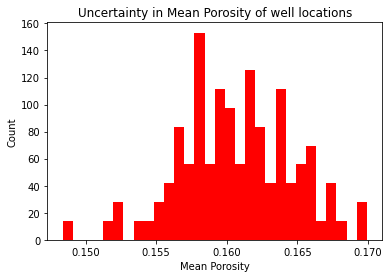

In [34]:
sample_array = sim_sk.flatten()

wells = np.array([])                               #an array of random samples of our SGSIM model

for i in range(0,50):                              #want to drill 50 wells
    index = np.random.randint(0,len(sample_array)) #want to pull from entire 10,000 data points of SGSIM model
    wells = np.append(wells,sample_array[index])

mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times we drill 50 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(wells)):
        index = np.random.randint(0,len(wells))
        samples = np.append(samples,wells[index])  #builds 1 full realization of 50 wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)

#Visualize uncertainty distribution in single SGSIM model:

bins = 30
plt.subplot(1,1,1)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity' )
plt.ylabel('Count')
plt.title('Uncertainty in Mean Porosity of well locations')
    
    

Now that we understand bootstrap in a single SGSIM model, lets follow the Journellian approach where we build multiple SGSIM models that all contribute to the total porosity distribution we will perform bootstrap on. We need to change the random number seed for the SGSIM model to ensure we get a new model every time we perform a bootstrap realization.

Its important that we keep the drill locations the same accross our SGSIM models for this approach. 


 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = 0.1558
                 Weighted Variance             = 0.0008
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9873
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1486 (close to 0.0?)
                                   variance = 0.9249 (close to gammabar(V,V)? approx. 1.0)
drill_loc  [8447. 1204. 2290. 9046. 3869. 3261. 6335. 8395. 4986. 1491. 6332. 9172.
 1186. 2839. 2579.  704. 8

Text(0.5, 1.0, 'Journelian Bootstrap')

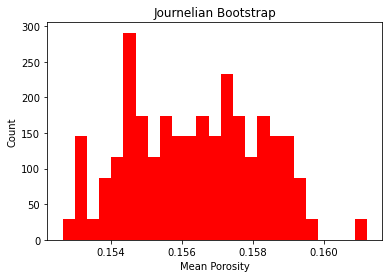

In [35]:
SGSIMreals = 0   #of SGSIM Models for a distribution
ndata = 50
reals = 1        # only run the 
sample_array = sim_sk.flatten()


#take the SGSIM code(minus visualization) from above and work it into a loop for automation.

wells = np.array([]) 
drill_loc = np.array([])
for i in range(0,50):                                   #drill 50 wells in the same location so we store this in 'drill_loc'
    index = int(np.random.randint(0,len(sample_array))) #pull from entire 10,000 data points of SGSIM model
    drill_loc = np.append(drill_loc,index)

while SGSIMreals < 5:           #number of isotropic SGSIM models for global distribution
    SGSIMreals += 1
    
    nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
    ndmin = 0; ndmax = 10; radius = 400; skmean = 0
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=100,hmin1=100)
    tmin = -999; tmax = 999

#SGSIM model
    rand =  np.random.randint(0,100)
    sim_sk = geostats.sgsim(df_iso,'X','Y','porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
                twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=rand,
                ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

    
    sample_array = sim_sk.flatten()
    print('drill_loc ',drill_loc)

    

    for i in range(0,len(drill_loc)):
        index1 = int(drill_loc[i])
        wells = np.append(wells,sample_array[index1])
        
# by now we have our global distribution of wells drilled in multiple SGSIM models at the same locations 
# now perform bootstrap

print('# wells ',len(wells))        
mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times sample 250 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(wells)):
        index = np.random.randint(0,len(wells))
        samples = np.append(samples,wells[index])  #builds 1 full realization of all wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)
    
print('bins ',len(mean_por))
#Visualize
    
bins = 25
plt.subplot(1,1,1)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity')
plt.ylabel('Count')
plt.title('Journelian Bootstrap')


Lets get some summary statistics on our realizations.

In [36]:
JournelRealsDF = pd.DataFrame(mean_por, columns = ['Journelian Mean Porosity'])
JournelRealsDF.describe()

,Journelian Mean Porosity
count,100.000000
mean,0.156356
std,0.001849
min,0.152625
25%,0.154850
50%,0.156418
75%,0.157797
max,0.161220


This distribution can serve as our basis for comparing a similar method but with a imposed drilling strategy

### Method 2: Journellian Bootstrap with Imposed Strategy


To apply our drilling strategy to our isotropic SGSIM models, we simply impelment our decision criteria into the sampling process from before.

Lets first decide on 'sufficiently high' and 'sufficiently low' porosity values by looking at our original summary statistics.

In [39]:
porosity.describe()

,porosity
count,100.000000
mean,0.155795
std,0.028945
min,0.103921
25%,0.128661
50%,0.154913
75%,0.182014
max,0.199775


Threshold Porosity (P75):  0.17553910960993674


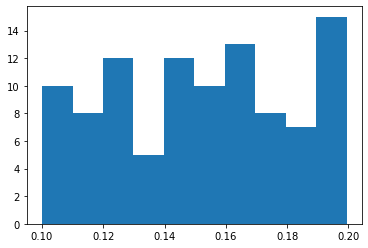

In [83]:
porosity_stats = np.array(porosity)

plt.hist(porosity_stats)
threshold_por = np.percentile(porosity_stats,75)
print('Threshold Porosity (P75): ',threshold_por)

We choose any porosity sampled below the P75 to be sufficiently low and a 'bad well' and any porosity sampled above the P75 to be sufficiently high and a 'good well'.

### Implement Strategy

Now lets implement our strategy into our sampling process using loops. Before we implement this into our journellian method, lets demonstrate the process on a single SGSIM model.

Our strategy loop will be worked into the sampling loop before we perform bootstrap so that we have our 'filtered' porosity distribution. 

We first need to develope a method to selectively sample from our defined annular region. 

### Build Annular Region
Recall the Equation of a circle.

source: https://youtu.be/JvDpYlyKkNU


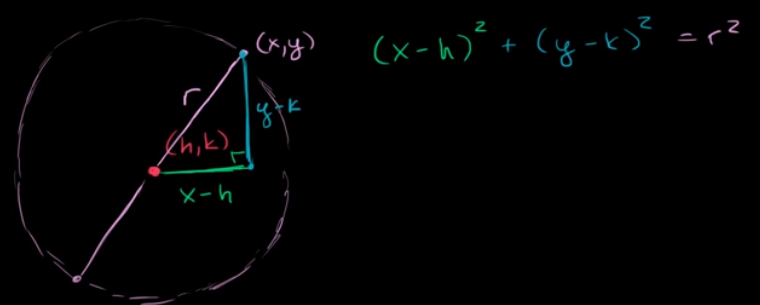

In [93]:
print('source: https://youtu.be/JvDpYlyKkNU')
Image("Equation of a Circle.PNG")



The output of our SGSIM model is an array of porosity values overlayed on X-Y coordinate arrays that we can use to define our annular regions with circles.

Once the anular region is defined, we can take the corresponding porosity values for those selected X-Y coordinates.

Lets define our inner and outer circles with the equation of a circle.

In [107]:
df_iso

,X,Y,porosity
0,130.0,459.0,0.109905
1,300.0,100.0,0.115932
2,900.0,894.0,0.184721
3,800.0,600.0,0.193171
4,920.0,969.0,0.153883
...,...,...,...
95,670.0,779.0,0.177307
96,180.0,359.0,0.158016
97,940.0,169.0,0.193278
98,370.0,689.0,0.113850


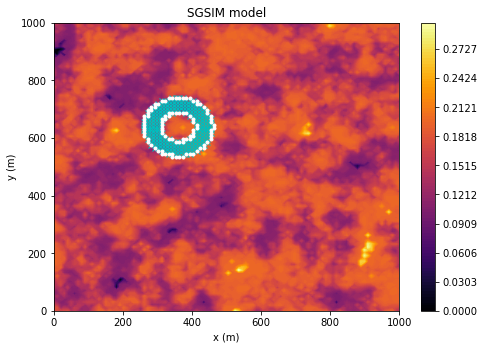

In [291]:
#data needs to come from SGSIM map
from scipy.interpolate import griddata

nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0

x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymax,ymin,ny)
X,Y = np.meshgrid(x,y)
px = X.flatten()
py = Y.flatten()

#Lets use Item 99 as a 'good well'. We take this well's X,Y coordinates as our 'h,k' for our eqation of a circle.

well_x = 360.0
well_y = 639.0
well_por = 0.199775

#define R1, R2 from major and minor axes, (here well assume R2 is 50% of R1 for demonstration
#since they are equal when Isotropic)

Hmaj = 100.0
Hmin = Hmaj/2

R1 = np.array([])
for i in range(len(px)):
    R1 = np.append(R1,np.sqrt((px[i]-well_x)**2 + (py[i]-well_y)**2))

annulus = np.where((R1 <= Hmaj)&(R1 > Hmin))[0]
outsideR1 = np.where(R1 > Hmaj)[0]
r1 = np.where(((R1 > Hmaj-5))&(R1<(Hmaj+5)))[0]
r2 = np.where(((R1 > Hmin-5))&(R1<(Hmin+5)))[0]

#--------------------------------------------------------------------------------------------------
#Re-create the contour plot to visualize the circular regions

points = np.column_stack((px,py))
values = sim_sk.flatten()
Z = griddata(points,values,(X,Y),method = 'cubic') 

fig,ax = plt.subplots()
levels = np.linspace(0.0,0.3,100)
#ax.invert_yaxis()
#ax.invert_xaxis()

C = ax.contourf(X,Y,Z, cmap = 'inferno',levels = levels)
fig.colorbar(C)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.2, hspace=0.2)
cbar.set_label('Porosity')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('SGSIM model')

annulusx = np.array([])
annulusy = np.array([])
annuluspor = np.array([])
insideR2x = np.array([])
insideR2y = np.array([])
insideR2por = np.array([])
r1x = np.array([])
r1y = np.array([])
r2x = np.array([])
r2y = np.array([])

for i in r1:
    r1x = np.append(r1x,px[i])
    r1y = np.append(r1y,py[i])
for i in r2:
    r2x = np.append(r2x,px[i])
    r2y = np.append(r2y,py[i])

for i in annulus:
    annulusx = np.append(annulusx,px[i])
    annulusy = np.append(annulusy,py[i])
    annuluspor = np.append(annuluspor,sim_sk.flatten()[i])
    
plt.plot(annulusx,annulusy,'cx')
plt.plot(r1x,r1y,'w.')
plt.plot(r2x,r2y,'w.')


# of wells  15
[0.18923879 0.17815234 0.19974101 0.1819371  0.19693521 0.19318347
 0.17606332 0.19266341 0.19009022 0.19304533 0.19080205 0.19317896
 0.19293784 0.17770279 0.19974746]


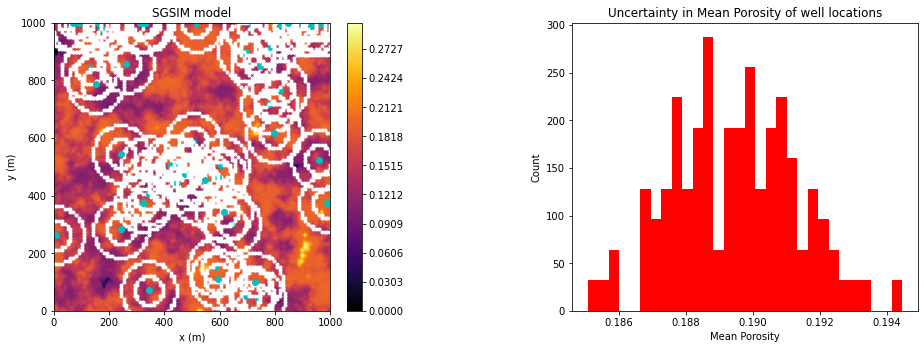

In [309]:
sample_array = sim_sk.flatten()
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0

x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymax,ymin,ny)
X,Y = np.meshgrid(x,y)
px = X.flatten()
py = Y.flatten()

points = np.column_stack((px,py))
values = sim_sk.flatten()
Z = griddata(points,values,(X,Y),method = 'cubic') 
levels = np.linspace(0.0,0.3,100)

ax = plt.subplot(121)
ax.contourf(X,Y,Z, cmap = 'inferno',levels = levels)
C = ax.contourf(X,Y,Z, cmap = 'inferno',levels = levels)
plt.colorbar(C)
cbar.set_label('Porosity')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('SGSIM model')

#sampling loop(apply strategy here)
wells = np.array([])                               #an array of filterd samples from our SGSIM model using srategy
index = np.random.randint(0,len(sample_array)) #want to pull from entire 10,000 data points of SGSIM model

wellx = np.array([])
welly = np.array([])
for i in range(0,50):                              #want to drill 50 wells

    well_x = px[index]
    well_y = py[index]
    well_por = sample_array[index]

    #define R1, R2 from major and minor axes, (here well assume R2 is 50% of R1 for demonstration
    #since they are equal when Isotropic)
    Hmaj = 100.0
    Hmin = Hmaj/2
    R1 = np.array([])
    for i in range(len(px)):
        R1 = np.append(R1,np.sqrt((px[i]-well_x)**2 + (py[i]-well_y)**2))
        
    annulus = np.where((R1 <= Hmaj)&(R1 > Hmin))[0]
    outsideR1 = np.where(R1 > Hmaj)[0]
    
    r1 = np.where(((R1 > Hmaj-5))&(R1<(Hmaj+5)))[0]
    r2 = np.where(((R1 > Hmin-5))&(R1<(Hmin+5)))[0]
    annulusx = np.array([])
    annulusy = np.array([])
    annuluspor = np.array([])
    
    annulusx = np.array([])
    annulusy = np.array([])
    annuluspor = np.array([])
    badwellpor = np.array([])
    insideR2x = np.array([])
    insideR2y = np.array([])
    insideR2por = np.array([])
    r1x = np.array([])
    r1y = np.array([])
    r2x = np.array([])
    r2y = np.array([])

    for i in r1:
        r1x = np.append(r1x,px[i])
        r1y = np.append(r1y,py[i])
    for i in r2:
        r2x = np.append(r2x,px[i])
        r2y = np.append(r2y,py[i])

    for i in annulus:
        annulusx = np.append(annulusx,px[i])
        annulusy = np.append(annulusy,py[i])
        annuluspor = np.append(annuluspor,sim_sk.flatten()[i])
    for i in outsideR1:
        badwellpor = np.append(badwellpor,sim_sk.flatten()[i])
    
    if well_por >= threshold_por:                        #if a good well, sample stored
        wells = np.append(wells,sample_array[index])
        index = np.random.randint(0,len(annuluspor))
    elif well_por < threshold_por:                       #if below threshold, sample not stored, and look outside annulus
        index = np.random.randint(0,len(badwellpor))
        
   
    ax.plot(well_x,well_y,'co')
    ax.plot(r1x,r1y,'w.')
    ax.plot(r2x,r2y,'w.')
        
       # wells = np.append(wells,sample_array[index]) 
print('# of wells ', len(wells))
print(wells)

    
#Bootstrap Loop
mean_por = np.array([])
n = 0
while n < 100:                                     #n realizations (number of times we drill 50 wells)
    n+=1
    samples = np.array([])
    for i in range(0,len(wells)):
        index = np.random.randint(0,len(wells))
        samples = np.append(samples,wells[index])  #builds 1 full realization of 50 wells
    mean = np.mean(samples)
    mean_por = np.append(mean_por,mean)
    

#Visualize uncertainty distribution in single SGSIM model:

bins = 30
ax2 = plt.subplot(122)
n, bins,patches = plt.hist(mean_por,bins,facecolor = 'r',density=True)
plt.xlabel('Mean Porosity' )
plt.ylabel('Count')
plt.title('Uncertainty in Mean Porosity of well locations')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=.5, hspace=.5)


We see that the number of acceptable wells samples is significanlty lower than the 50 wells we planned to drill.

Now lets implement this strategy into our journellian Bootstrap approach.
We dont want to remove a bad sample's drilling locaiton because if we do we are essentially not drilling in that same location again when applying new SGSIM models whichs ignores the new information present by these new models. Therefore we want to keep our locations stored and only capture good porosity samples from all locations.

of the three loops in place:

- Setting Drill Locations
- Sampling Porosity from Drill Locations
- Bootstrap

we are applying our threshold porosity to the second loop where sampling from a SGSIM model is done



### Dealing With Anisotropy:
- We determined that R1, the outer limit of the annular region used to define a close new well, would be the major axis range of the variogram used in our SGSIM models. After calculating the variogram for our raw data, I observed geometric anisotropy in the spatial data and determined the major and minor azimuths. For the drilling strategy, defining an annular region surrounding a sample to randomly drill another well seems naive if we have a gerneral idea of where high porosity zones lie(45 degree azimuth), and where worse porosity is (135 degreee azimuth).  
- The idea of drilling close to or far from the previous drill depending on how good the sample was makes sense. However, I think I should implement more directionality in the strategy that will make the selection of a new drill less random Maybe within the annular region, if you had a good well and want to drill another close well, drill within the annulus, but make sure to drill along the 45 degree azimuth and avoid the 135 degree azimuth. And of course always avoid drilling within R2 (minor axis range of our variogram model).

- here's and image that explains my thinking.

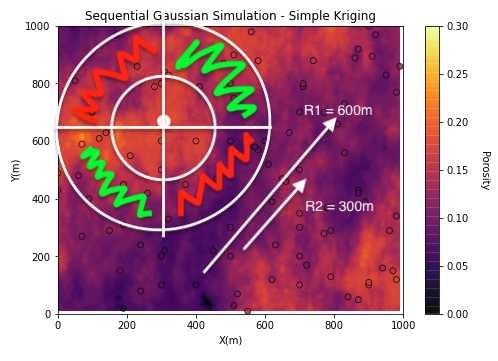

In [13]:
Image("Strategy visual.png")